In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lib.dataset_utils import *
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

### Load Data

In [2]:
train_df, val_df, test_df = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)
label_names = train_df.columns[1:]

In [3]:
train_df.head(20)

,text,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
5,ive been feeling a little burdened lately wasn...,0,0,0,0,1,0
6,ive been taking or milligrams or times recomme...,0,0,0,0,0,1
7,i feel as confused about life as a teenager or...,0,1,0,0,0,0
8,i have been with petronas for years i feel tha...,0,0,1,0,0,0
9,i feel romantic too,0,0,0,1,0,0


### Explore Data

In [4]:
train_df.isna().sum()

text        0
anger       0
fear        0
joy         0
love        0
sadness     0
surprise    0
dtype: int64

No nan found

### Twitter mentions and hashtags

In [5]:
# find twitter mentions and hashtags
occ = train_df['text'].str.findall(r'@(\w+)|#(\w+)')
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()

array([], dtype=object)

Very few records have user tags and reddit tags

### Links in text

In [6]:
# find links in the text
occ = train_df['text'].str.findall(r"(?: ^|\b)https?://\S+")
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()
print(occ)
occ = train_df['text'].str.findall(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)')
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()
print(occ)

Series([], dtype: object)
Series([], dtype: object)


Sampling data, we found that links are present, but exist related to whitespaced tokens href, http, www

In [14]:
# get number of records with at least one tag
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    print(f'{name}: {len(dataset[dataset["text"].str.contains(r"(?: href|http|www)")])}')

train: 203
val: 25
test: 26


In [15]:
# retrieve records
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    print(f'{name}: {dataset[dataset["text"].str.contains(r"(?: href|http|www)")]}')

train:                                                     text  anger  fear  joy  \
125    i feel they are pretty safe on my blog img src...      0     0    1   
323    i stopped feeling so exhausted a href http pro...      0     0    0   
462                  i feel so dazed a href http twitter      0     0    0   
640                          i feel so carefree nowwwwww      0     0    1   
866    i feel unwelcome at work sometimes and think p...      0     0    0   
...                                                  ...    ...   ...  ...   
15509        i feel like i should be offended but yawwwn      1     0    0   
15518  i feel honoured to be asked thanks a href http...      0     0    1   
15732  i feel like it was just a title mimm fall insp...      0     0    1   
15779  i cant always identify with peoples struggles ...      0     0    0   
15784  i get the added bonus of feeling superior and ...      0     0    1   

       love  sadness  surprise  
125       0        0   

No links found

### Distribution of text and labels over the split

#### Label Balance

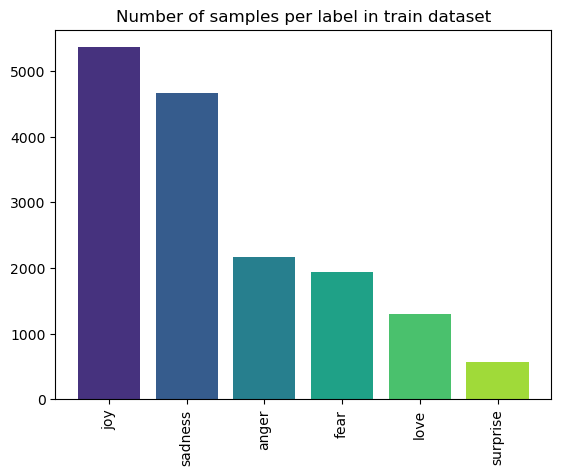

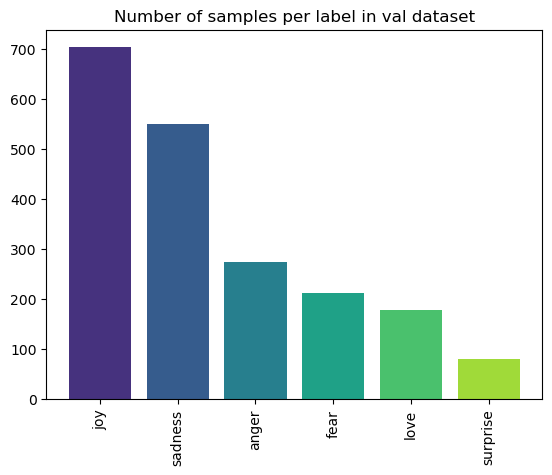

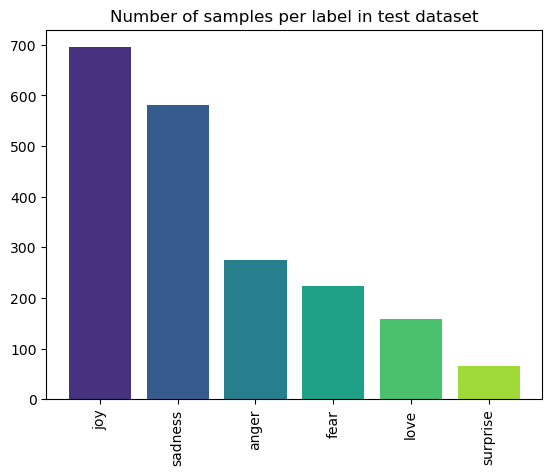

In [19]:
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    # bar plot of the number of samples per label
    dataset_labels = dataset[label_names].values
    counts = np.sum(dataset_labels, axis=0)
    # sort by counts
    sorted_idx = np.argsort(counts)[::-1]
    sorted_label_names = label_names[sorted_idx]
    counts = counts[sorted_idx]
    plt.bar(sorted_label_names, counts, color=sns.color_palette("viridis", len(sorted_label_names)))
    plt.xticks(rotation=90)
    plt.title(f'Number of samples per label in {name} dataset')
    plt.show()

#### Text Length and word count

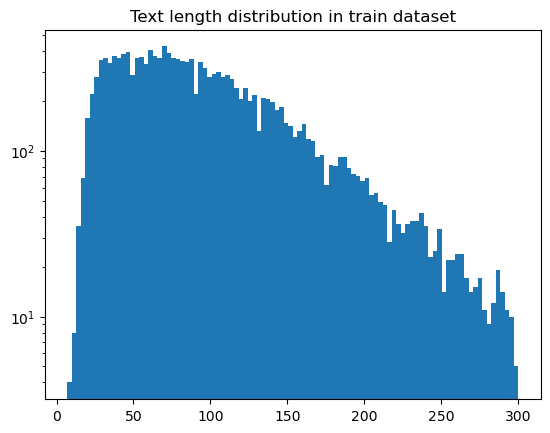

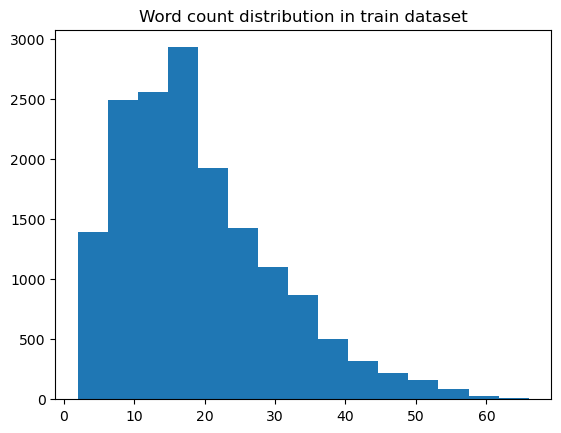

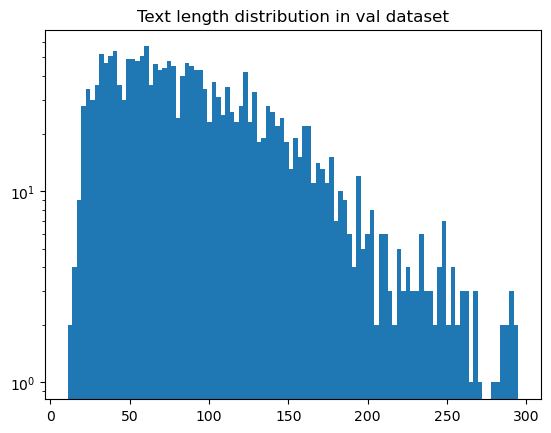

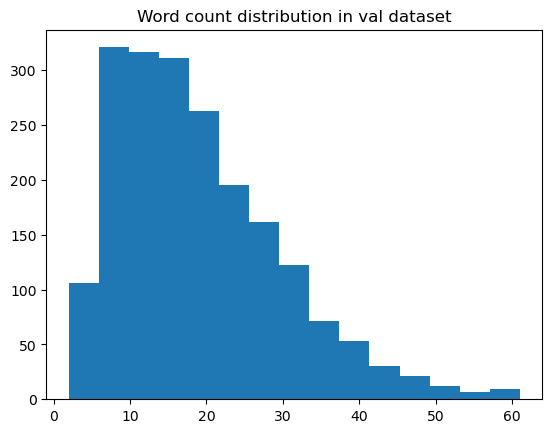

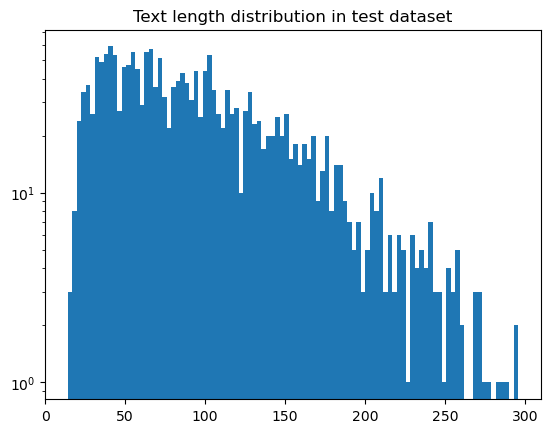

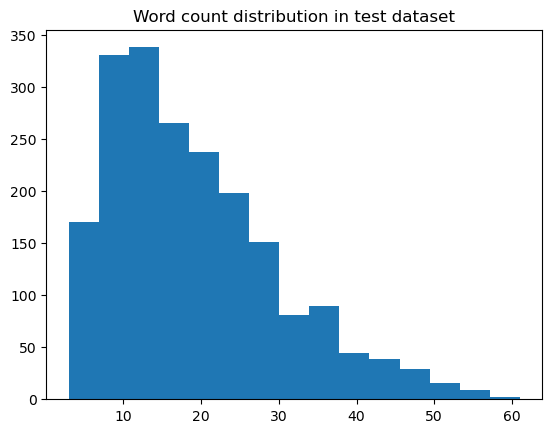

In [20]:
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    # text length histogram
    dataset['text_len'] = dataset['text'].apply(lambda x: len(x))
    dataset['text_len'].hist(bins=100)
    plt.title(f'Text length distribution in {name} dataset')
    plt.yscale('log')
    plt.grid(False)
    plt.show()
    # word count histogram
    dataset['word_count'] = dataset['text'].apply(lambda x: len(x.split()))
    dataset['word_count'].hist(bins=15)
    plt.title(f'Word count distribution in {name} dataset')
    plt.grid(False)
    plt.show()

#### Text length and word count by label

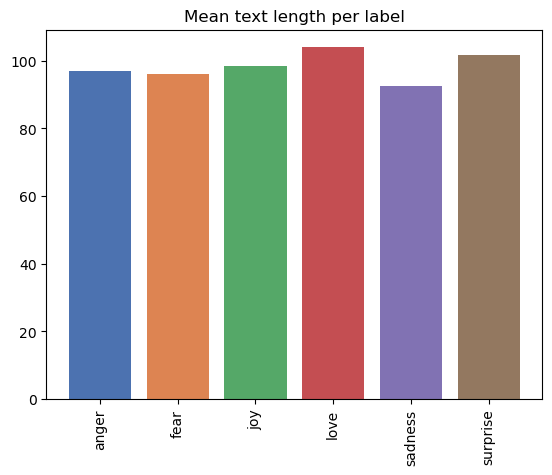

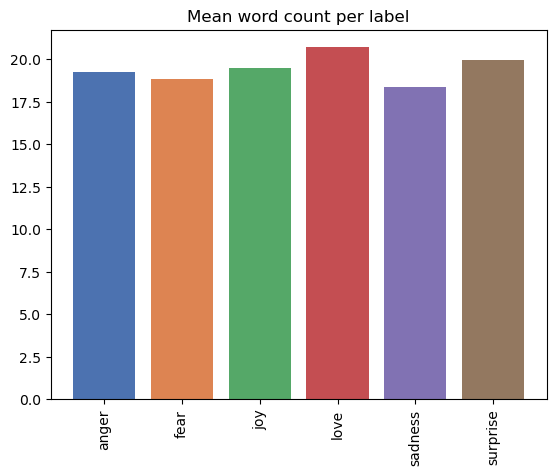

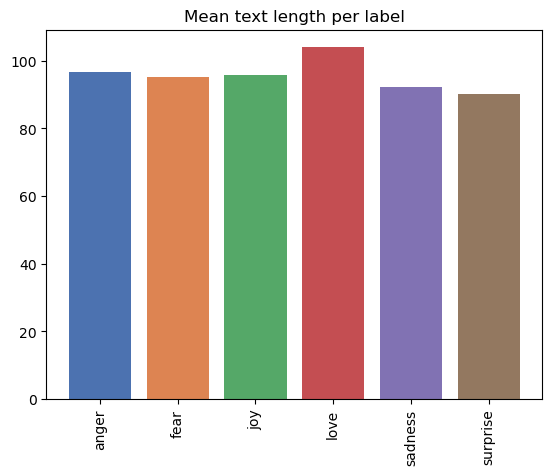

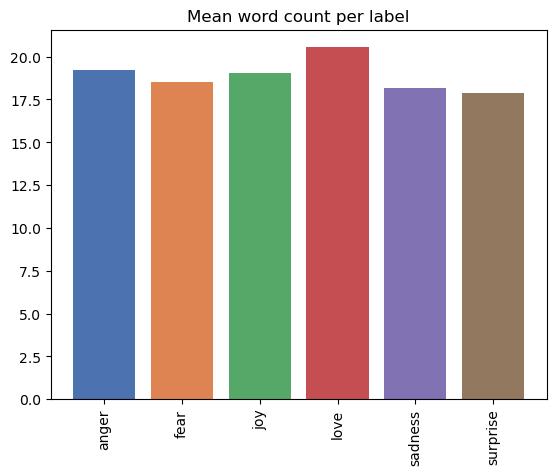

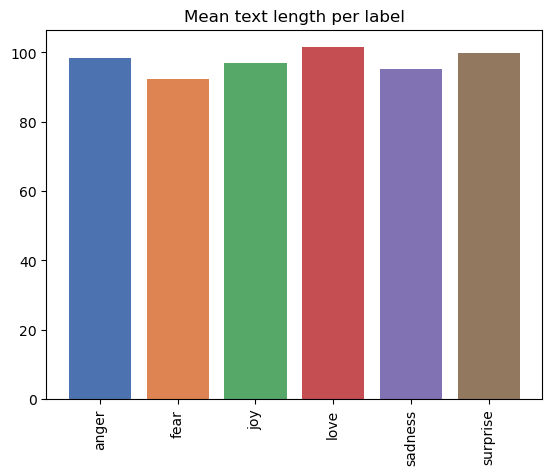

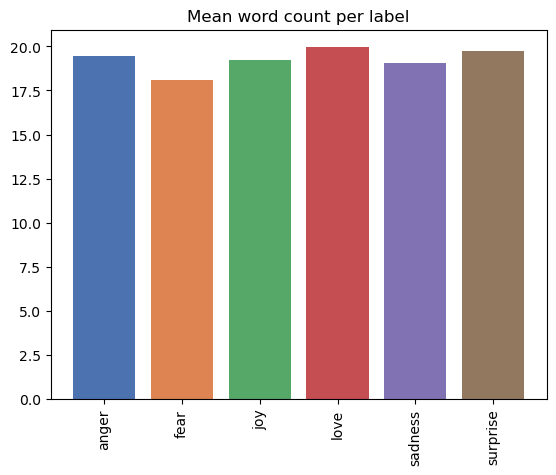

In [21]:
# mean text length per label and word count per label
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    avg_text_len = []
    avg_word_count = []
    for label in label_names:
        label_mask = dataset[label] == 1
        label_text_len = dataset[label_mask]['text_len']
        label_word_count = dataset[label_mask]['word_count']
        avg_text_len.append(np.mean(label_text_len))
        avg_word_count.append(np.mean(label_word_count))
    plt.bar(label_names, avg_text_len, color=sns.color_palette('deep', len(label_names)))
    plt.xticks(rotation=90)
    plt.title('Mean text length per label')
    plt.show()
    plt.bar(label_names, avg_word_count, color=sns.color_palette('deep', len(label_names)))
    plt.xticks(rotation=90)
    plt.title('Mean word count per label')
    plt.show()